In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from io import StringIO
from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
class DatasetClass(Dataset):
    
    def __init__(self, folder, filename, label_dict):
        
        self.data = []
        self.filename = filename
        tar = tarfile.open(folder + '/' + filename)
        for file in tar.getmembers():
            f = tar.extractfile(file)
            if f != None:
                content = pd.read_csv(StringIO(f.read().decode()), sep=' ', header=None).values.ravel()
                self.data.append(content)
            
        self.y = torch.tensor(label_dict[self.filename[:-7]], dtype=torch.long)
    
    def __getitem__(self, idx):     
        
        return torch.tensor(self.data[idx], dtype=torch.float), self.y
      
    def __len__(self):
        
        return len(self.data)

In [60]:
def train_test_loader(directory, label_dict, train_fraction=0.8, num_workers=2, batch_size=32):

    all_files = list(filter(lambda x: x.endswith('.tar.gz'), os.listdir(directory)))
    files = [file for file in all_files if file[:-7] in label_dict.keys()]
    
    datasets = list(map(lambda x : DatasetClass(directory, x, label_dict), files))
    dataset = ConcatDataset(datasets)
    N = dataset.cumulative_sizes[-1]
    
    train_size = int(N*train_fraction)
    test_size = N - train_size

    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return trainloader, testloader, train_size, test_size

In [61]:
label_dict = {'tallbuilding': 0, 'opencountry':1, 'mountain': 2, 'highway': 3, 'coast': 4}
# trainloader, testloader = train_test_loader('Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, num_workers=0)
trainloader, testloader, train_size, test_size = train_test_loader('/content/drive/My Drive/Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, num_workers=0)

In [205]:
class AutoEncoder(nn.Module):
    
    def __init__(self, n_features, h_layer_sizes):
        super(AutoEncoder, self).__init__()
        
        self.fc1 = nn.Linear(n_features, h_layer_sizes[0])
        self.fc2 = nn.Linear(h_layer_sizes[0], h_layer_sizes[1])
        self.fc3 = nn.Linear(h_layer_sizes[1], h_layer_sizes[2])
        self.out = nn.Linear(h_layer_sizes[2], n_features)
        
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x)) # Hidden Layer 1 (Tanh)
        x = self.fc2(x)    # Hidden Layer 2 (Linear)
        x = torch.tanh(self.fc3(x)) # Hidden Layer 3 (Tanh)
        x = self.out(x) # Output Layer (Linear)
        
        return x
    
    def get_z(self, x):
        
        z = torch.tanh(self.fc1(x))
        z = self.fc2(z)
        
        return z

In [206]:
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [207]:
ae1 = AutoEncoder(828, [500, 350, 500])
ae1 = ae1.to(device)
optimizer1 = optim.SGD(ae1.parameters(), lr=0.0001, momentum=0.9)

In [208]:
old_loss = np.inf
losses = []
max_epoch = 500

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        optimizer1.zero_grad()
        
        # Reconstructed Representation of X (forward)
        X_hat = ae1(X)
        
        # Calculate Loss (MSE)
        loss = criterion(X_hat, X)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer1.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)
    print(abs(running_loss-old_loss)/running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 1e-4:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 1.9474741653962573
inf
Epoch 2 : Loss = 1.9238737957044079
0.012267109071574194
Epoch 3 : Loss = 1.9002036289735273
0.01245664747186433
Epoch 4 : Loss = 1.8769811337644404
0.012372258192341175
Epoch 5 : Loss = 1.8537627946246753
0.01252497849621912
Epoch 6 : Loss = 1.8300247869708315
0.012971413186777877
Epoch 7 : Loss = 1.8054557063362815
0.013608243363891083
Epoch 8 : Loss = 1.7796280356970704
0.014512960079938582
Epoch 9 : Loss = 1.7523625167933379
0.015559291323821462
Epoch 10 : Loss = 1.723361633040689
0.016828089471552173
Epoch 11 : Loss = 1.6924726312810718
0.018250813152728182
Epoch 12 : Loss = 1.6596073074774305
0.019803072483210504
Epoch 13 : Loss = 1.6246520443396137
0.021515538209921917
Epoch 14 : Loss = 1.5876750512556599
0.02329002591223532
Epoch 15 : Loss = 1.5486139790578326
0.02522324654565743
Epoch 16 : Loss = 1.5077093975110485
0.02713028227741372
Epoch 17 : Loss = 1.46491970799186
0.02920958007851864
Epoch 18 : Loss = 1.4205408177592538
0.0312408412

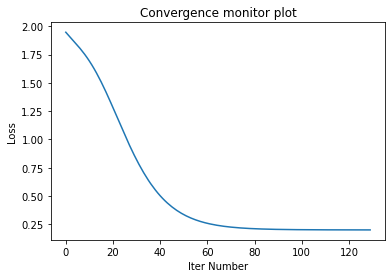

In [209]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [226]:
class FinalNet(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FinalNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        # self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        #self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.out = nn.Linear(hidden_sizes[1], num_classes)
    
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))
        #x = torch.tanh(self.fc4(x))
        x = self.out(x)
        
        return x
    
    def predict(self, X):
        
        with torch.no_grad():
            y_score = self.forward(X)
            y_pred = torch.argmax(y_score, axis=1)
            
        return y_pred
            
    
classifier = FinalNet(350, [200, 50], 5)

In [241]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.000001, momentum=0.9)
classifier = classifier.to(device)

In [242]:
old_loss = np.inf

max_epoch = 5000
# losses= []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        # extracting encoder features from AE1 to use as input to the MLFFNN
        with torch.no_grad():
            Z = ae1.get_z(X)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(Z)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    print(abs(running_loss-old_loss)/running_loss)
    losses.append(running_loss)

    if abs(running_loss-old_loss)/running_loss < 1e-10:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 0.9606887928464194
inf
Epoch 2 : Loss = 0.960336762395772
0.00036656979554665624
Epoch 3 : Loss = 0.9599651748483832
0.00038708440381449415
Epoch 4 : Loss = 0.9597038518298755
0.00027229547741150414
Epoch 5 : Loss = 0.9595532620495016
0.00015693738568738953
Epoch 6 : Loss = 0.9593770111149005
0.00018371394411081457
Epoch 7 : Loss = 0.9592653052373361
0.00011644940868233982
Epoch 8 : Loss = 0.9591273787346754
0.00014380415544253957
Epoch 9 : Loss = 0.9589805738492447
0.0001530843162352696
Epoch 10 : Loss = 0.9589083127000116
7.535772531747222e-05
Epoch 11 : Loss = 0.9588954231955786
1.3442033532766498e-05
Epoch 12 : Loss = 0.9588286768306387
6.961239953794498e-05
Epoch 13 : Loss = 0.9587970782410015
3.295649345862046e-05
Epoch 14 : Loss = 0.9587709903717043
2.7209698206480235e-05
Epoch 15 : Loss = 0.9587859077887101
1.55586527550985e-05
Epoch 16 : Loss = 0.9587264237078756
6.204489556509148e-05
Epoch 17 : Loss = 0.9586998237804932
2.7745835268349362e-05
Epoch 18 : Loss 

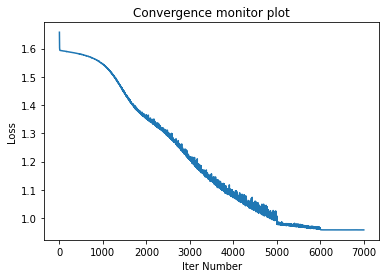

In [243]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [244]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        Z = ae1.get_z(X)
        y_hat = classifier(Z)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.cpu().detach().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Train Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Train Loss = 3.8338096141815186


,0,1,2,3,4
0,166,20,67,11,16
1,11,259,27,2,40
2,62,50,149,12,27
3,16,4,9,132,41
4,8,71,24,32,152


In [245]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        Z = ae1.get_z(X)
        y_hat = classifier(Z)      
        test_loss += criterion(y_hat, y)
        
        y_test.extend(list(y.cpu().detach().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 12.9644136428833


,0,1,2,3,4
0,37,5,27,4,3
1,3,45,10,1,12
2,19,16,26,8,5
3,6,3,6,31,12
4,6,19,4,8,36


In [246]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.4971590909090909 Test Precision = 0.5028440782696778 Test F1 = 0.49949105090012347


In [ ]:
torch.save(classifier.state_dict(), 'a2_q1_wts.pt')

# PCA

In [16]:
# To fit the PCA model we load all the training points in a single batch
# train, test = train_test_loader('Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, batch_size=2000, num_workers=0)
train, test = train_test_loader('/content/drive/My Drive/Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, batch_size=2000, num_workers=0)

99% Variance Explained: 295


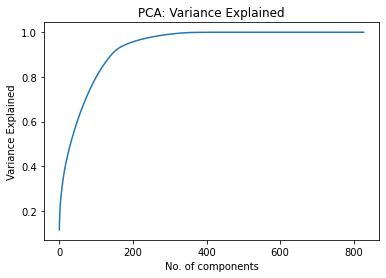

In [247]:
kk = 0
for i in train:
    temp = i[0]

pca1 = PCA(n_components=temp.shape[1])
pca1.fit(temp)

print('99% Variance Explained:', np.where(np.cumsum(pca1.explained_variance_ratio_)>=0.99)[0][0]+1)
explained_var = np.cumsum(pca1.explained_variance_ratio_)
plt.plot(explained_var)
plt.title('PCA: Variance Explained')
plt.xlabel('No. of components')
plt.ylabel('Variance Explained')
plt.show()

In [24]:
def return_pca(temp):
    pca = PCA(n_components=0.99)
    pca.fit(temp)
    return pca

PCA_model = return_pca(temp)

In [43]:
reduced_dimension = PCA_model.transform(temp).shape[1]
pca_clf = FinalNet(reduced_dimension, [150, 75, 50], 5)

In [44]:
reduced_dimension

295

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pca_clf.parameters(), lr=0.001, momentum=0.9)
pca_clf = pca_clf.to(device)

Epoch 1 : Loss = 70.1593987941742
Epoch 2 : Loss = 68.89605939388275
Epoch 3 : Loss = 67.52734839916229
Epoch 4 : Loss = 66.02605032920837
Epoch 5 : Loss = 64.3612322807312
Epoch 6 : Loss = 62.58863294124603
Epoch 7 : Loss = 60.877670645713806
Epoch 8 : Loss = 59.21260070800781
Epoch 9 : Loss = 57.61559176445007
Epoch 10 : Loss = 56.05080699920654
Epoch 11 : Loss = 54.48280048370361
Epoch 12 : Loss = 52.88495051860809
Epoch 13 : Loss = 51.34216821193695
Epoch 14 : Loss = 49.79651081562042
Epoch 15 : Loss = 48.3210534453392
Epoch 16 : Loss = 46.9161514043808
Epoch 17 : Loss = 45.543405055999756
Epoch 18 : Loss = 44.24747294187546
Epoch 19 : Loss = 43.02239269018173
Epoch 20 : Loss = 41.84241473674774
Epoch 21 : Loss = 40.72730928659439
Epoch 22 : Loss = 39.66628223657608
Epoch 23 : Loss = 38.67802172899246
Epoch 24 : Loss = 37.74628925323486
Epoch 25 : Loss = 36.84521508216858
Epoch 26 : Loss = 35.969343304634094
Epoch 27 : Loss = 35.15179789066315
Epoch 28 : Loss = 34.381955742836
Epoc

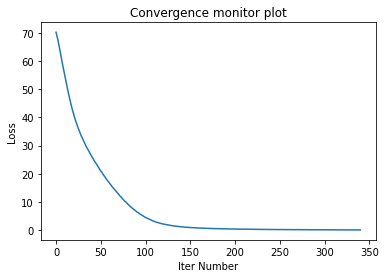

In [47]:
old_loss = np.inf

max_epoch = 500
losses= []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0], data[1].to(device)
        
        # applying PCA on the data to use as input to the MLFFNN
        Z = torch.Tensor(PCA_model.transform(X)).to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = pca_clf(Z)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)

    if abs(running_loss-old_loss)/running_loss < 0.005 and running_loss<0.15:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [48]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in trainloader:

        X, y = data[0], data[1].to(device)
        Z = torch.Tensor(PCA_model.transform(X)).to(device)
        y_hat = pca_clf(Z)      
        test_loss += criterion(y_hat, y)
        
        y_test.extend(list(y.cpu().detach().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Train Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Train Loss = 0.1481517255306244


,0,1,2,3,4
0,283,0,0,0,0
1,0,326,0,0,0
2,0,0,300,0,0
3,0,0,0,198,0
4,0,0,0,0,301


In [54]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0], data[1].to(device)
        Z = torch.Tensor(PCA_model.transform(X)).to(device)
        y_hat = pca_clf(Z)      
        test_loss += criterion(y_hat, y)
        
        y_test.extend(list(y.cpu().detach().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [50]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.6079545454545454 Test Precision = 0.6152641469080431 Test F1 = 0.6019215164445282
